In [4]:
import torch
from torch import Tensor
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
#core pacakges
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
import cv2
from shutil import copyfile
#google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

cuda:0


In [16]:
!unzip '/content/drive/MyDrive/!personalMLProject/portraitSegmentation/portraitSegData/archive.zip'

Streaming output truncated to the last 5000 lines.
  inflating: ytrain/13698.png        
  inflating: ytrain/13699.png        
  inflating: ytrain/13700.png        
  inflating: ytrain/13701.png        
  inflating: ytrain/13702.png        
  inflating: ytrain/13703.png        
  inflating: ytrain/13704.png        
  inflating: ytrain/13705.png        
  inflating: ytrain/13706.png        
  inflating: ytrain/13707.png        
  inflating: ytrain/13708.png        
  inflating: ytrain/13709.png        
  inflating: ytrain/13710.png        
  inflating: ytrain/13711.png        
  inflating: ytrain/13712.png        
  inflating: ytrain/13713.png        
  inflating: ytrain/13714.png        
  inflating: ytrain/13715.png        
  inflating: ytrain/13716.png        
  inflating: ytrain/13717.png        
  inflating: ytrain/13718.png        
  inflating: ytrain/13719.png        
  inflating: ytrain/13720.png        
  inflating: ytrain/13721.png        
  inflating: ytrain/13722.png        

In [1]:
def visualize_dataset(aDataset):
  fig, axes = plt.subplots(5, 2, figsize=(10, 20))

  for i in range(5):
    random_index = random.randint(0, len(aDataset) - 1)
    image, mask = aDataset[random_index]

    numpy_mask = mask.detach().numpy()
    numpy_image = image.detach().numpy()*255.0

    #switch channel to last position for visualization
    if numpy_image.shape[0] == 3:
        numpy_image = np.transpose(numpy_image, (1, 2, 0))
    if numpy_mask.shape[0] == 1:
        numpy_mask = np.transpose(numpy_mask, (1,2,0))

    numpy_image = numpy_image.astype(np.uint8)

    axes[i, 0].imshow(numpy_image)
    axes[i, 0].set_title("Image")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(numpy_mask, cmap='gray')
    axes[i, 1].set_title("Mask")
    axes[i, 1].axis('off')

    # print (f'image shape {numpy_image.shape}')
    # print (f'mask shape {numpy_mask.shape}')
    #print(f'mask tensor {mask}')
    unique_vals_mask = torch.unique(mask)
    #print(f'mask tensor unqiue vals {unique_vals_mask}')

    #print(f'image tensor {image}')
    unique_vals_img = torch.unique(image)
    #print(f'image tensor unqiue vals {unique_vals_img}')

  plt.tight_layout()
  plt.show()

In [6]:
class portraitSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        # Load images as uint8
        image = np.array(Image.open(img_path).convert('RGB'), dtype=np.uint8)
        mask = np.array(Image.open(mask_path).convert('L'), dtype=np.uint8)

        image = image/255.0
        #print(image)

        # Convert mask to binary values
        mask[mask == 255] = 1

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']  # Should be torch.Tensor
            mask = augmented['mask']    # Should be torch.Tensor

        else:
            # If no transform, convert to tensor
            image = torch.from_numpy(image.transpose(2, 0, 1)).float()
            mask = torch.from_numpy(mask).unsqueeze(0).float()

        # # Ensure image is float32 and scaled properly
        image = image.float()
        mask = mask.float()

        return image, mask

In [7]:
xtest_dir = '/content/xtest'
xtrain_dir = '/content/xtrain'
ytest_dir = '/content/ytest'
ytrain_dir = '/content/ytrain'
#len of xtrain and y train dir
print(len(os.listdir(xtrain_dir)))
print(len(os.listdir(ytrain_dir)))


18698
18698


In [18]:
#alubmentations transformations
train_augment = A.Compose([
    #alubmentation normalize distinguishes images(3 chan) from masks (1 chan)
    A.Resize(height=128, width=128, p=1),
    A.Rotate(limit=35, p=0.2),
    A.HorizontalFlip(p=0.2),
    A.VerticalFlip(p=0.1),
    A.Affine(scale=1.0, translate_percent=0.1, shear=5, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, p=1.0),
    ToTensorV2(),
])

val_preprocess = A.Compose([
    A.Resize(height=128, width=128, p=1),
    ToTensorV2(),
])


In [19]:
#takes in path for train and its mask dir, split img/mask pathes for train/val split. Stored in val folder
def train_dir_to_train_val_split(train_img_dir, train_mask_dir):
  # List all files in the image directory
  image_filenames = os.listdir(train_img_dir)

  mask_filenames = os.listdir(train_mask_dir) #can do this because mask, image have the same names

  # Sort and match image files with mask files by name
  image_filenames.sort()
  mask_filenames.sort()

  train_images, val_images, train_masks, val_masks = train_test_split(
    image_filenames, mask_filenames, test_size=0.2, random_state=42
  )

  trainSplit_image_dir = '/content/xtrain_split'
  val_image_dir = '/content/xval_split'
  trainSplit_mask_dir = '/content/ytrain_split'
  val_mask_dir = '/content/yval_split'

  os.makedirs(trainSplit_image_dir, exist_ok=True)
  os.makedirs(val_image_dir, exist_ok=True)
  os.makedirs(trainSplit_mask_dir, exist_ok=True)
  os.makedirs(val_mask_dir, exist_ok=True)

  # Copy training files
  for img, mask in zip(train_images, train_masks):
      copyfile(os.path.join(train_img_dir, img), os.path.join(trainSplit_image_dir, img))
      copyfile(os.path.join(train_mask_dir, mask), os.path.join(trainSplit_mask_dir, mask))

  # Copy validation files
  for img, mask in zip(val_images, val_masks):
      copyfile(os.path.join(train_img_dir, img), os.path.join(val_image_dir, img))
      copyfile(os.path.join(train_mask_dir, mask), os.path.join(val_mask_dir, mask))

  print(f'Training images: {len(train_images)}, Validation images: {len(val_images)}')

In [ ]:
#train test split with new folders
train_dir_to_train_val_split(xtrain_dir, ytrain_dir)

In [21]:
# Initialize dataset with transformations and preprocessing function
xtrain_dir = '/content/xtrain_split'
ytrain_dir = '/content/ytrain_split'
xval_dir = '/content/xval_split'
yval_dir = '/content/yval_split'
batch_size = 24

train_dataset = portraitSegmentationDataset(image_dir=xtrain_dir, mask_dir=ytrain_dir, transform=train_augment)
val_dataset = portraitSegmentationDataset(image_dir=xval_dir, mask_dir=yval_dir, transform=val_preprocess)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


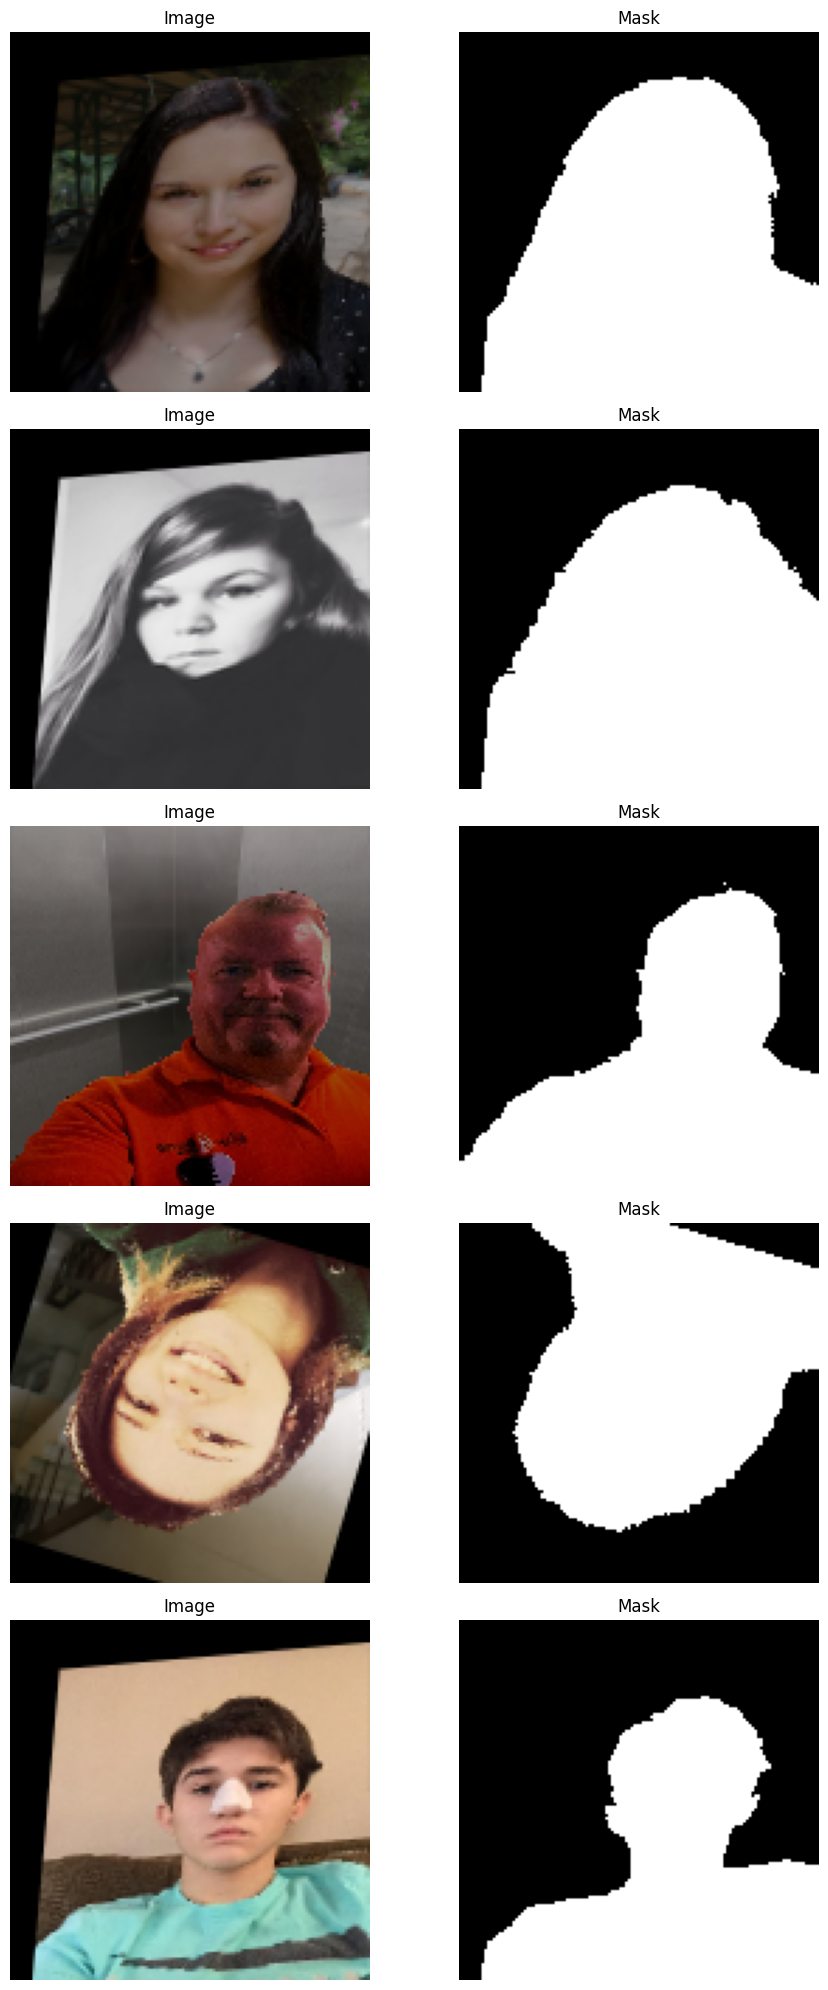

In [22]:
visualize_dataset(train_dataset)

In [29]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [30]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [31]:
uNetModel = UNet(3, 1)
uNetModel.to(device)
summary(uNetModel, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,728
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,864
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
        DoubleConv-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,728
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,456
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14          [-1, 128,

In [32]:
#Dice score for gauging model performance
def diceScore(predicted, target, epsilon=1e-6):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target)
    dice_score = (2 * intersection + epsilon) / (union + epsilon)
    return dice_score


In [33]:
optimizer = optim.Adam(uNetModel.parameters(),lr=0.0001, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
best_dice_loss = float('inf')
best_dice_score = 0.0
best_epoch = 0

for epoch in range(100):
    # Training loop
    uNetModel.train()

    totalLoss = 0.0
    totalDice = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).float()
        outputs = uNetModel(images)

        loss = criterion(outputs.squeeze(1), masks)

        probs = torch.sigmoid(outputs)
        binary_masks = (probs > 0.5).float()
        dice=diceScore(outputs, binary_masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        totalDice += dice.item()*images.size(0)
        totalLoss += loss.item() * images.size(0)
    print(f'epoch {epoch}, loss: {totalLoss/len(train_loader.dataset)}, dice: {totalDice/len(train_loader.dataset)}')

    if epoch % 10 == 0:
        torch.save(uNetModel.state_dict(), f'/content/uNetModel_epoch_{epoch}.pth')

    if totalLoss/len(train_loader.dataset) < best_dice_loss:
        best_dice_loss = totalLoss/len(train_loader.dataset)
        best_dice_score = totalDice/len(train_loader.dataset)
        best_epoch = epoch
        torch.save(uNetModel.state_dict(), '/content/uNetModel_best.pth')
        print(f"saved best model at epcoh {best_epoch} with dice loss {best_dice_loss} and dice score {best_dice_score}")

print(f'model best weight at epoch {best_epoch} with dice loss {best_dice_loss} and dice score {best_dice_score}')